First we show the code used, and at the end we show the results and its analysis and conclusions.

# RBF MODEL

In [203]:
# Features of the model
features = ['Pclass', 'Sex', 'Age', 'SibSp', 'Parch', 'Fare', 'Embarked']
# Transform dataframe in numpy arrays
X = df[features].values
y = df['Survived'].values



# Test set will be the 25% taken randomly
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=33)

# Preprocess: normalize
#scaler = preprocessing.StandardScaler().fit(X_train)
#X_train = scaler.transform(X_train)
#X_test = scaler.transform(X_test)

# Define model

In [207]:

types_of_kernels = ['linear', 'rbf', 'poly']

rbf = types_of_kernels[1]
gamma = 3.0

model = SVC(kernel=rbf, probability=True, gamma=gamma)


# Train and evaluate

In [208]:
#This step will take some time 
# Train - This is not needed if you use K-Fold

model.fit(X_train, y_train)

predicted = model.predict(X_test)
expected = y_test

In [209]:
# Accuracy
metrics.accuracy_score(expected, predicted)

0.61434977578475336

~82% accuracy in example

~61.4% using rbf kernel


## Null accuracy

We can evaluate the accuracy if the model always predict the most frequent class, following this [refeference](http://blog.kaggle.com/2015/10/23/scikit-learn-video-9-better-evaluation-of-classification-models/).

In [210]:
# Count number of samples per class
s_y_test = Series(y_test)
s_y_test.value_counts()

0    134
1     89
dtype: int64

In [211]:
# Mean of ones
y_test.mean()

0.3991031390134529

In [212]:
# Mean of zeros
1 - y_test.mean() 


0.60089686098654704

In [213]:
# Calculate null accuracy (binary classification coded as 0/1)
max(y_test.mean(), 1 - y_test.mean())

0.60089686098654704

In [214]:
# Calculate null accuracy (multiclass classification)
s_y_test.value_counts().head(1) / len(y_test)

0    0.600897
dtype: float64

Accuracy is 61.4% so there is no such a difference between null accuracy (60%) and accuracy

## Confussion matrix and F-score

In [215]:
# Confusion matrix
print(metrics.confusion_matrix(expected, predicted))

[[128   6]
 [ 80   9]]


[[115 19]
 [23  66]] in example, [[128 6] [80 9]] now

In [47]:
# Report
print(classification_report(expected, predicted))

             precision    recall  f1-score   support

          0       0.62      0.96      0.75       134
          1       0.60      0.10      0.17        89

avg / total       0.61      0.61      0.52       223



## ROC (Receiver Operating Characteristic ) and AUC (Area Under the Curve)

The [ROC](https://en.wikipedia.org/wiki/Receiver_operating_characteristic)  curve illustrates the performance of a binary classifier system as its discrimination threshold is varied.

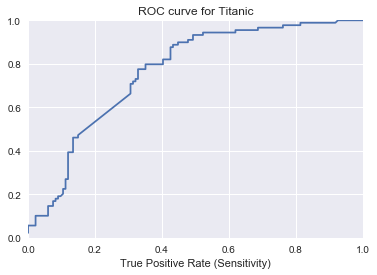

In [48]:
y_pred_prob = model.predict_proba(X_test)[:,1]
fpr, tpr, thresholds = roc_curve(y_test, y_pred_prob)
plt.plot(fpr, tpr)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.0])
plt.title('ROC curve for Titanic')
plt.xlabel('False Positive Rate (1 - Recall)')
plt.xlabel('True Positive Rate (Sensitivity)')
plt.grid(True)

In [49]:
#Threshold used by the decision function, thresholds[0] is the number of 
thresholds

array([ 0.84566552,  0.84558346,  0.84558327,  0.83709556,  0.792093  ,
        0.77843147,  0.76697138,  0.43390406,  0.42845051,  0.42771864,
        0.42180721,  0.42086889,  0.41930861,  0.41422397,  0.41420059,
        0.4101296 ,  0.409959  ,  0.40945211,  0.40926107,  0.40904838,
        0.40904597,  0.4090007 ,  0.4090007 ,  0.4090007 ,  0.4090007 ,
        0.4090007 ,  0.4090007 ,  0.4090007 ,  0.4090007 ,  0.4090007 ,
        0.4090007 ,  0.4090007 ,  0.4090007 ,  0.40900065,  0.40900061,
        0.40900031,  0.40899805,  0.40896604,  0.40885943,  0.40839914,
        0.40837954,  0.40832288,  0.40803821,  0.40788978,  0.40023888,
        0.39564318,  0.3951413 ,  0.39512774,  0.39512448,  0.39511498,
        0.36491197,  0.36039451,  0.2230382 ,  0.21993954,  0.21853064,
        0.17477549,  0.17475846,  0.17473475,  0.17472338,  0.1746746 ,
        0.17466021,  0.17465674,  0.17458967,  0.17458751,  0.17457517,
        0.17456757,  0.17452059,  0.17446313,  0.16372597])

array([<matplotlib.axes._subplots.AxesSubplot object at 0x00000207518134E0>,
       <matplotlib.axes._subplots.AxesSubplot object at 0x00000207518B2CF8>], dtype=object)

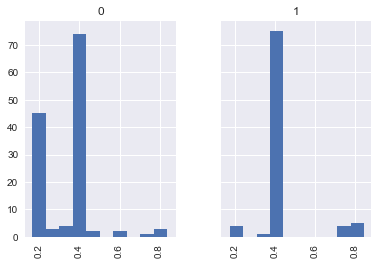

In [50]:
#Histogram of probability vs actual
dprob = pd.DataFrame(data = {'probability':y_pred_prob, 'actual':y_test})
dprob.probability.hist(by=dprob.actual, sharex=True, sharey=True)

ROC curve helps to select a threshold to balance sensitivity and recall.

In [51]:
#Function to evaluate thresholds of the ROC curve
def evaluate_threshold(threshold):
    print('Sensitivity:', tpr[thresholds > threshold][-1])
    print('Recall:', 1 - fpr[thresholds > threshold][-1])

In [52]:
evaluate_threshold(0.74)

Sensitivity: 0.101123595506
Recall: 0.977611940299


In [53]:
evaluate_threshold(0.5)

Sensitivity: 0.101123595506
Recall: 0.977611940299


By default, the thresdhold to decide a class is 0.5, If we modify it, we should use the new thresdhold.

threshold = 0.8

predicted = model.predict_proba(X) > threshold

In [54]:
# AUX
print(roc_auc_score(expected, predicted))

0.528173738051


# Train and Evaluate with K-Fold

In [55]:
# This step will take some time
# Cross-validation
cv = KFold(X.shape[0], n_folds=5, shuffle=False, random_state=33)
# StratifiedKFold has is a variation of k-fold which returns stratified folds:
# each set contains approximately the same percentage of samples of each target class as the complete set.
#cv = StratifiedKFold(y, n_folds=3, shuffle=False, random_state=33)
scores = cross_val_score(model, X, y, cv=cv)
print("Scores in every iteration", scores)
print("Accuracy: %0.2f (+/- %0.2f)" % (scores.mean(), scores.std() * 2))


Scores in every iteration [ 0.70391061  0.59550562  0.66292135  0.62921348  0.62921348]
Accuracy: 0.64 (+/- 0.07)


We get 64% of success with K-Fold, worse than linear example

<module 'matplotlib.pyplot' from 'C:\\Users\\ignacio.pascual\\AppData\\Local\\Continuum\\anaconda3\\lib\\site-packages\\matplotlib\\pyplot.py'>

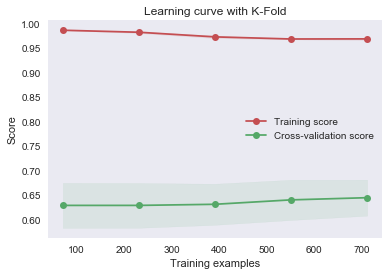

In [56]:
plot_learning_curve(model, "Learning curve with K-Fold", X, y, cv=cv)

# Train and Optimize

In [57]:
#Tune parameters
gammas = np.logspace(-6, -1, 10)
gs = GridSearchCV(model, param_grid=dict(gamma=gammas))
gs.fit(X_train, y_train)
scores = gs.score(X_test, y_test)
print(scores)

0.67264573991


<module 'matplotlib.pyplot' from 'C:\\Users\\ignacio.pascual\\AppData\\Local\\Continuum\\anaconda3\\lib\\site-packages\\matplotlib\\pyplot.py'>

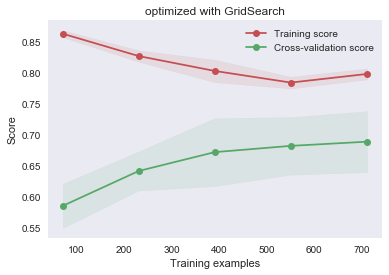

In [60]:
# Refine model
model = SVC(kernel='rbf', gamma=gs.best_estimator_.gamma)
plot_learning_curve(model, "optimized with GridSearch", X, y, cv=cv)

# Visualise

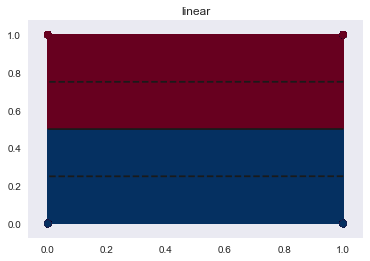

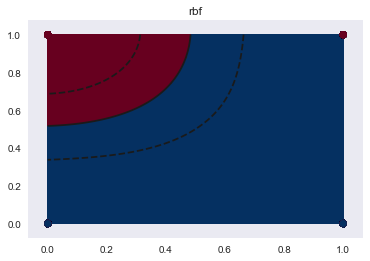

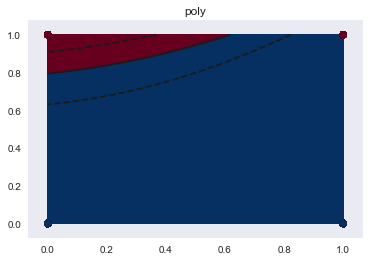

In [61]:
# Plot with standard configuration of SVM
%run plot_svm
plot_svm(df)

Any value in the blue survived while anyone in the read did not. Checkout the graph for the linear transformation. It created its decision boundary right on 50%! 

# RBF (Normalized Data)

In [62]:
# Features of the model
features = ['Pclass', 'Sex', 'Age', 'SibSp', 'Parch', 'Fare', 'Embarked']
# Transform dataframe in numpy arrays
X = df[features].values
y = df['Survived'].values



# Test set will be the 25% taken randomly
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=33)

# Preprocess: normalize
scaler = preprocessing.StandardScaler().fit(X_train)
X_train = scaler.transform(X_train)
X_test = scaler.transform(X_test)

# Define model

In [63]:

types_of_kernels = ['linear', 'rbf', 'poly']

rbf = types_of_kernels[1]
gamma = 3.0

model = SVC(kernel=rbf, probability=True, gamma=gamma)


# Train and evaluate

In [64]:
#This step will take some time 
# Train - This is not needed if you use K-Fold

model.fit(X_train, y_train)

predicted = model.predict(X_test)
expected = y_test

In [65]:
# Accuracy
metrics.accuracy_score(expected, predicted)

0.80717488789237668

~82% accuracy in example

~61.4% using rbf kernel

~80.71% using rbf with normalized data

## Null accuracy

We can evaluate the accuracy if the model always predict the most frequent class, following this [refeference](http://blog.kaggle.com/2015/10/23/scikit-learn-video-9-better-evaluation-of-classification-models/).

In [66]:
# Count number of samples per class
s_y_test = Series(y_test)
s_y_test.value_counts()

0    134
1     89
dtype: int64

In [67]:
# Mean of ones
y_test.mean()

0.3991031390134529

In [68]:
# Mean of zeros
1 - y_test.mean() 


0.60089686098654704

In [69]:
# Calculate null accuracy (binary classification coded as 0/1)
max(y_test.mean(), 1 - y_test.mean())

0.60089686098654704

In [70]:
# Calculate null accuracy (multiclass classification)
s_y_test.value_counts().head(1) / len(y_test)

0    0.600897
dtype: float64

So, since our accuracy was 0.82 is better than the null accuracy.

## Confussion matrix and F-score

In [71]:
# Confusion matrix
print(metrics.confusion_matrix(expected, predicted))

[[112  22]
 [ 21  68]]


[[115 19]
 [23  66]] in example, [[128 6] [80 9]] rbf, [[112 22] [21 68]] rbf norm

In [72]:
# Report
print(classification_report(expected, predicted))

             precision    recall  f1-score   support

          0       0.84      0.84      0.84       134
          1       0.76      0.76      0.76        89

avg / total       0.81      0.81      0.81       223



## ROC (Receiver Operating Characteristic ) and AUC (Area Under the Curve)

The [ROC](https://en.wikipedia.org/wiki/Receiver_operating_characteristic)  curve illustrates the performance of a binary classifier system as its discrimination threshold is varied.

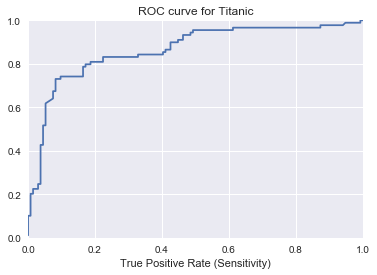

In [73]:
y_pred_prob = model.predict_proba(X_test)[:,1]
fpr, tpr, thresholds = roc_curve(y_test, y_pred_prob)
plt.plot(fpr, tpr)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.0])
plt.title('ROC curve for Titanic')
plt.xlabel('False Positive Rate (1 - Recall)')
plt.xlabel('True Positive Rate (Sensitivity)')
plt.grid(True)

In [74]:
#Threshold used by the decision function, thresholds[0] is the number of 
thresholds

array([ 0.84204829,  0.81456811,  0.81100345,  0.81093962,  0.8108993 ,
        0.80608775,  0.80452199,  0.79794497,  0.79476302,  0.78831705,
        0.78714929,  0.68333301,  0.65118747,  0.56992687,  0.56648351,
        0.50546169,  0.5       ,  0.49327225,  0.49318834,  0.49119686,
        0.49116993,  0.49115806,  0.4849034 ,  0.47873872,  0.47450644,
        0.47410167,  0.46844728,  0.46818945,  0.3773183 ,  0.36710044,
        0.31367315,  0.31364152,  0.23140795,  0.22972666,  0.20448485,
        0.20221339,  0.2013472 ,  0.19788697,  0.19479574,  0.19224596,
        0.18681351,  0.18532918,  0.18404945,  0.18059763,  0.17336165,
        0.17242978,  0.17216539,  0.17188686,  0.16948882,  0.16947257,
        0.16937349,  0.16934995,  0.16933488,  0.16900106,  0.16897388,
        0.16878911,  0.16874494,  0.1686083 ,  0.16852057,  0.16749853,
        0.16741918,  0.16537565,  0.16527664,  0.14218613,  0.14198774,
        0.13856782])

array([<matplotlib.axes._subplots.AxesSubplot object at 0x0000020751B0F400>,
       <matplotlib.axes._subplots.AxesSubplot object at 0x0000020751AD4A20>], dtype=object)

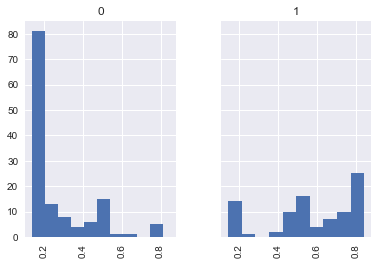

In [75]:
#Histogram of probability vs actual
dprob = pd.DataFrame(data = {'probability':y_pred_prob, 'actual':y_test})
dprob.probability.hist(by=dprob.actual, sharex=True, sharey=True)

ROC curve helps to select a threshold to balance sensitivity and recall.

In [76]:
#Function to evaluate thresholds of the ROC curve
def evaluate_threshold(threshold):
    print('Sensitivity:', tpr[thresholds > threshold][-1])
    print('Recall:', 1 - fpr[thresholds > threshold][-1])

In [78]:
evaluate_threshold(0.74)

Sensitivity: 0.247191011236
Recall: 0.962686567164


In [79]:
evaluate_threshold(0.5)

Sensitivity: 0.61797752809
Recall: 0.94776119403


In [80]:
# AUX
print(roc_auc_score(expected, predicted))

0.799932919671


# Train and Evaluate with K-Fold

This is alternative to splitting the dataset into train and test. It will run k times slower than the other method, but it will be more accurate.

In [81]:
# This step will take some time
# Cross-validation
cv = KFold(X.shape[0], n_folds=5, shuffle=False, random_state=33)
# StratifiedKFold has is a variation of k-fold which returns stratified folds:
# each set contains approximately the same percentage of samples of each target class as the complete set.
#cv = StratifiedKFold(y, n_folds=3, shuffle=False, random_state=33)
scores = cross_val_score(model, X, y, cv=cv)
print("Scores in every iteration", scores)
print("Accuracy: %0.2f (+/- %0.2f)" % (scores.mean(), scores.std() * 2))


Scores in every iteration [ 0.70391061  0.59550562  0.66292135  0.62921348  0.62921348]
Accuracy: 0.64 (+/- 0.07)


We get 64% of success with K-Fold, better as before, but still low (at the moment, we have more algorithms)

<module 'matplotlib.pyplot' from 'C:\\Users\\ignacio.pascual\\AppData\\Local\\Continuum\\anaconda3\\lib\\site-packages\\matplotlib\\pyplot.py'>

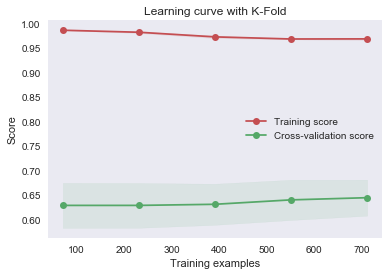

In [82]:
plot_learning_curve(model, "Learning curve with K-Fold", X, y, cv=cv)

# Train and Optimize

In [83]:
#Tune parameters
gammas = np.logspace(-6, -1, 10)
gs = GridSearchCV(model, param_grid=dict(gamma=gammas))
gs.fit(X_train, y_train)
scores = gs.score(X_test, y_test)
print(scores)

0.847533632287


<module 'matplotlib.pyplot' from 'C:\\Users\\ignacio.pascual\\AppData\\Local\\Continuum\\anaconda3\\lib\\site-packages\\matplotlib\\pyplot.py'>

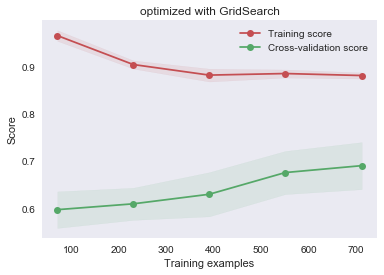

In [84]:
# Refine model
model = SVC(kernel='rbf', gamma=gs.best_estimator_.gamma)
plot_learning_curve(model, "optimized with GridSearch", X, y, cv=cv)

# Visualise

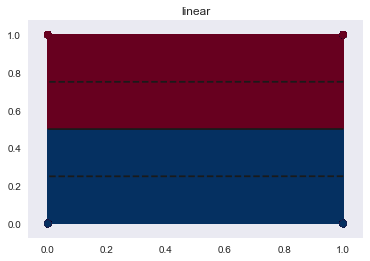

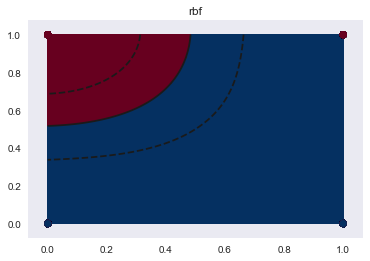

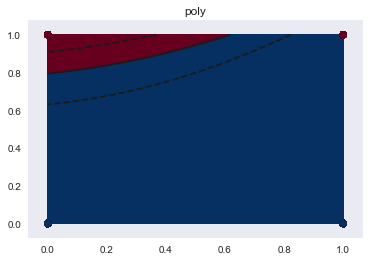

In [85]:
# Plot with standard configuration of SVM
%run plot_svm
plot_svm(df)

Any value in the blue survived while anyone in the read did not. Checkout the graph for the linear transformation. It created its decision boundary right on 50%! 

# Gaussian NB

In [116]:
# Features of the model
features = ['Pclass', 'Sex', 'Age', 'SibSp', 'Parch', 'Fare', 'Embarked']
# Transform dataframe in numpy arrays
X = df[features].values
y = df['Survived'].values



# Test set will be the 25% taken randomly
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=33)

# Preprocess: normalize
#Automatically done by gnb

# Define model

In [117]:
from sklearn.naive_bayes import GaussianNB
gnb = GaussianNB()

# Train and evaluate

In [118]:
#This step will take some time 
# Train - This is not needed if you use K-Fold

model=gnb.fit(X_train, y_train)

predicted = model.predict(X_test)
expected = y_test

In [119]:
# Accuracy
metrics.accuracy_score(expected, predicted)

0.81614349775784756

~82% accuracy in example

~61.4% using rbf kernel

~80.71% using rbf with normalized data

~81.61% using Gaussian Naive Bayes classificator

## Null accuracy

In [120]:
# Count number of samples per class
s_y_test = Series(y_test)
s_y_test.value_counts()

0    134
1     89
dtype: int64

In [121]:
# Mean of ones
y_test.mean()

0.3991031390134529

In [122]:
# Mean of zeros
1 - y_test.mean() 


0.60089686098654704

In [123]:
# Calculate null accuracy (binary classification coded as 0/1)
max(y_test.mean(), 1 - y_test.mean())

0.60089686098654704

In [124]:
# Calculate null accuracy (multiclass classification)
s_y_test.value_counts().head(1) / len(y_test)

0    0.600897
dtype: float64

So, since our accuracy was 0.82 is better than the null accuracy.

## Confussion matrix and F-score

In [125]:
# Confusion matrix
print(metrics.confusion_matrix(expected, predicted))

[[115  19]
 [ 22  67]]


[[115 19]
 [23  66]] in example, [[128 6] [80 9]] rbf, [[112 22] [21 68]] rbf norm, [[115 19] [22 67]] gaussiannb

In [126]:
# Report
print(classification_report(expected, predicted))

             precision    recall  f1-score   support

          0       0.84      0.86      0.85       134
          1       0.78      0.75      0.77        89

avg / total       0.82      0.82      0.82       223



## ROC (Receiver Operating Characteristic ) and AUC (Area Under the Curve)

The [ROC](https://en.wikipedia.org/wiki/Receiver_operating_characteristic)  curve illustrates the performance of a binary classifier system as its discrimination threshold is varied.

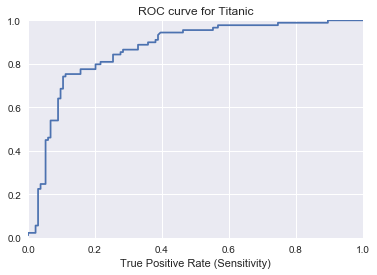

In [127]:
y_pred_prob = model.predict_proba(X_test)[:,1]
fpr, tpr, thresholds = roc_curve(y_test, y_pred_prob)
plt.plot(fpr, tpr)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.0])
plt.title('ROC curve for Titanic')
plt.xlabel('False Positive Rate (1 - Recall)')
plt.xlabel('True Positive Rate (Sensitivity)')
plt.grid(True)

In [128]:
#Threshold used by the decision function, thresholds[0] is the number of 
thresholds

array([  1.00000000e+00,   1.00000000e+00,   1.00000000e+00,
         9.99999602e-01,   9.99998715e-01,   9.89702760e-01,
         9.88600821e-01,   9.86704063e-01,   9.84896624e-01,
         7.95609799e-01,   7.95273223e-01,   7.93736357e-01,
         7.90212932e-01,   7.79490148e-01,   7.61426732e-01,
         7.50393815e-01,   7.48992511e-01,   7.47700628e-01,
         7.29401484e-01,   7.27880663e-01,   7.08639841e-01,
         7.04313730e-01,   6.95391339e-01,   6.19610558e-01,
         5.97467554e-01,   5.96537483e-01,   5.74214319e-01,
         5.61417241e-01,   4.61288889e-01,   3.95985759e-01,
         3.22281978e-01,   3.05997100e-01,   2.86607532e-01,
         2.46321311e-01,   2.20044035e-01,   2.01404468e-01,
         1.06527577e-01,   9.52216246e-02,   9.22377515e-02,
         9.12995928e-02,   8.93301644e-02,   8.71764444e-02,
         8.36554375e-02,   7.99920027e-02,   7.54418941e-02,
         7.52822452e-02,   7.46076650e-02,   7.33718409e-02,
         7.04494256e-02,

array([<matplotlib.axes._subplots.AxesSubplot object at 0x0000020751D0ABA8>,
       <matplotlib.axes._subplots.AxesSubplot object at 0x0000020751A70E10>], dtype=object)

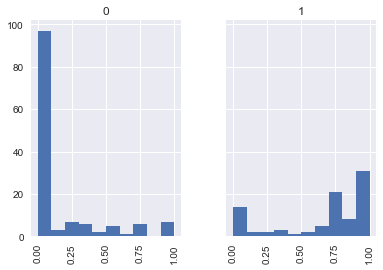

In [129]:
#Histogram of probability vs actual
dprob = pd.DataFrame(data = {'probability':y_pred_prob, 'actual':y_test})
dprob.probability.hist(by=dprob.actual, sharex=True, sharey=True)

In [130]:
#Function to evaluate thresholds of the ROC curve
def evaluate_threshold(threshold):
    print('Sensitivity:', tpr[thresholds > threshold][-1])
    print('Recall:', 1 - fpr[thresholds > threshold][-1])

In [132]:
evaluate_threshold(0.74)

Sensitivity: 0.573033707865
Recall: 0.910447761194


In [133]:
evaluate_threshold(0.5)

Sensitivity: 0.752808988764
Recall: 0.873134328358


In [134]:
# AUX
print(roc_auc_score(expected, predicted))

0.805508971994


# Train and Evaluate with K-Fold

This is alternative to splitting the dataset into train and test. It will run k times slower than the other method, but it will be more accurate.

In [135]:
# This step will take some time
# Cross-validation
cv = KFold(X.shape[0], n_folds=5, shuffle=False, random_state=33)
# StratifiedKFold has is a variation of k-fold which returns stratified folds:
# each set contains approximately the same percentage of samples of each target class as the complete set.
#cv = StratifiedKFold(y, n_folds=3, shuffle=False, random_state=33)
scores = cross_val_score(model, X, y, cv=cv)
print("Scores in every iteration", scores)
print("Accuracy: %0.2f (+/- %0.2f)" % (scores.mean(), scores.std() * 2))


Scores in every iteration [ 0.75977654  0.79213483  0.79213483  0.76966292  0.81460674]
Accuracy: 0.79 (+/- 0.04)


We get 79% of success with K-Fold, quite good!

<module 'matplotlib.pyplot' from 'C:\\Users\\ignacio.pascual\\AppData\\Local\\Continuum\\anaconda3\\lib\\site-packages\\matplotlib\\pyplot.py'>

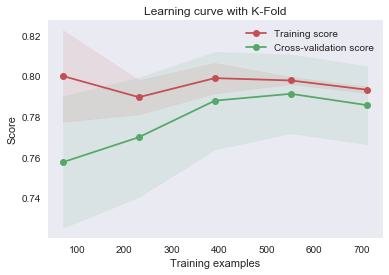

In [136]:
plot_learning_curve(model, "Learning curve with K-Fold", X, y, cv=cv)

# Visualise

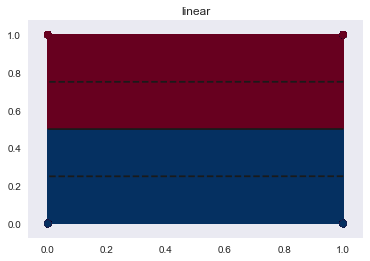

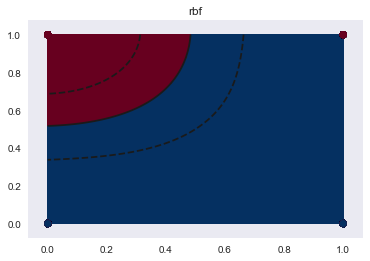

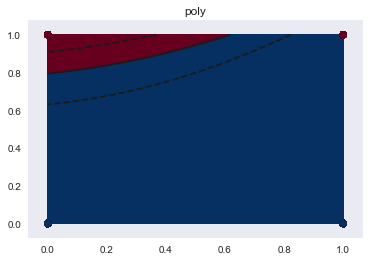

In [137]:
# Plot with standard configuration of SVM
%run plot_svm
plot_svm(df)

Any value in the blue survived while anyone in the read did not. Checkout the graph for the linear transformation. It created its decision boundary right on 50%! 

# Gaussian NB, with preprocessing (PCA) 


In [216]:
# Features of the model
features = ['Pclass', 'Sex', 'Age', 'SibSp', 'Parch', 'Fare', 'Embarked']
# Transform dataframe in numpy arrays
X = df[features].values
y = df['Survived'].values



# Test set will be the 25% taken randomly
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=33)

# Preprocess: normalize
scaler = preprocessing.StandardScaler().fit(X_train)
X_train = scaler.transform(X_train)
X_test = scaler.transform(X_test)

# Define model

In [217]:
from sklearn.naive_bayes import GaussianNB
from sklearn.decomposition import PCA
gnb = GaussianNB()


# Train and evaluate

In [218]:
# Perform PCA preproc. on standardized data(GNB based on standardized data)
pca_std = PCA(n_components=2).fit(X_train)
X_train = pca_std.transform(X_train)
X_test = pca_std.transform(X_test)

model=gnb.fit(X_train, y_train)

predicted = model.predict(X_test)
expected = y_test

In [219]:
# Accuracy
metrics.accuracy_score(expected, predicted)

0.65919282511210764

~82% accuracy in example

~61.4% using rbf kernel

~80.71% using rbf with normalized data

~81.61% using Gaussian Naive Bayes classificator (normalized)

~65.91% using PCA (Principle Component Analisis) preprocessing with GNB 

## Null accuracy

In [220]:
# Count number of samples per class
s_y_test = Series(y_test)
s_y_test.value_counts()

0    134
1     89
dtype: int64

In [221]:
# Mean of ones
y_test.mean()

0.3991031390134529

In [222]:
# Mean of zeros
1 - y_test.mean() 


0.60089686098654704

In [223]:
# Calculate null accuracy (binary classification coded as 0/1)
max(y_test.mean(), 1 - y_test.mean())

0.60089686098654704

In [224]:
# Calculate null accuracy (multiclass classification)
s_y_test.value_counts().head(1) / len(y_test)

0    0.600897
dtype: float64

So, since our accuracy was 65.91% is a bit better than the null accuracy.

## Confussion matrix and F-score

In [225]:
# Confusion matrix
print(metrics.confusion_matrix(expected, predicted))

[[103  31]
 [ 45  44]]


[[115 19]
 [23  66]] in example, [[128 6] [80 9]] rbf, [[112 22] [21 68]] rbf norm,
 
 [[103 31] [45 44]] gnb(pca)

In [226]:
# Report
print(classification_report(expected, predicted))

             precision    recall  f1-score   support

          0       0.70      0.77      0.73       134
          1       0.59      0.49      0.54        89

avg / total       0.65      0.66      0.65       223



## ROC (Receiver Operating Characteristic ) and AUC (Area Under the Curve)

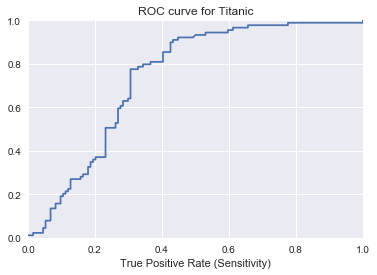

In [227]:
y_pred_prob = model.predict_proba(X_test)[:,1]
fpr, tpr, thresholds = roc_curve(y_test, y_pred_prob)
plt.plot(fpr, tpr)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.0])
plt.title('ROC curve for Titanic')
plt.xlabel('False Positive Rate (1 - Recall)')
plt.xlabel('True Positive Rate (Sensitivity)')
plt.grid(True)

In [228]:
#Threshold used by the decision function, thresholds[0] is the number of 
thresholds

array([ 0.98932636,  0.97948575,  0.97741325,  0.96283167,  0.92284858,
        0.92139986,  0.91691266,  0.88367951,  0.85003321,  0.83052767,
        0.82129789,  0.80012552,  0.79013207,  0.7782165 ,  0.77226307,
        0.77055484,  0.76000118,  0.7531806 ,  0.75008017,  0.74876156,
        0.73538811,  0.7078841 ,  0.67518434,  0.66574756,  0.66234428,
        0.65672048,  0.64906267,  0.63191445,  0.62582381,  0.62227061,
        0.62175656,  0.61432649,  0.61313602,  0.61226623,  0.57873011,
        0.49834236,  0.48352974,  0.47120116,  0.46814131,  0.41265081,
        0.41032974,  0.4053899 ,  0.40236567,  0.39884637,  0.36170483,
        0.3614554 ,  0.35921868,  0.3489926 ,  0.33825465,  0.32905534,
        0.3277762 ,  0.32636509,  0.31606444,  0.31564803,  0.31502442,
        0.31279712,  0.2976983 ,  0.29729422,  0.27154096,  0.2659888 ,
        0.26009883,  0.25954919,  0.25939623,  0.25163105,  0.24908447,
        0.24804466,  0.24718648,  0.23241225,  0.23099659,  0.21

array([<matplotlib.axes._subplots.AxesSubplot object at 0x00000207558DFC50>,
       <matplotlib.axes._subplots.AxesSubplot object at 0x0000020753750F60>], dtype=object)

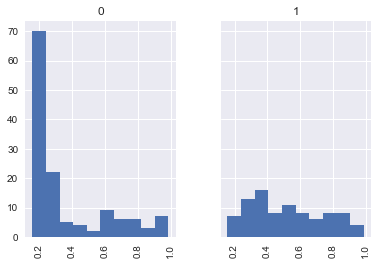

In [229]:
#Histogram of probability vs actual
dprob = pd.DataFrame(data = {'probability':y_pred_prob, 'actual':y_test})
dprob.probability.hist(by=dprob.actual, sharex=True, sharey=True)

In [230]:
#Function to evaluate thresholds of the ROC curve
def evaluate_threshold(threshold):
    print('Sensitivity:', tpr[thresholds > threshold][-1])
    print('Recall:', 1 - fpr[thresholds > threshold][-1])

In [231]:
evaluate_threshold(0.74)

Sensitivity: 0.224719101124
Recall: 0.880597014925


In [232]:
evaluate_threshold(0.5)

Sensitivity: 0.370786516854
Recall: 0.768656716418


In [233]:
# AUX
print(roc_auc_score(expected, predicted))

0.631519369445


# Train and Evaluate with K-Fold

In [234]:
# This step will take some time
# Cross-validation
cv = KFold(X.shape[0], n_folds=5, shuffle=False, random_state=33)
# StratifiedKFold has is a variation of k-fold which returns stratified folds:
# each set contains approximately the same percentage of samples of each target class as the complete set.
#cv = StratifiedKFold(y, n_folds=3, shuffle=False, random_state=33)
scores = cross_val_score(model, X, y, cv=cv)
print("Scores in every iteration", scores)
print("Accuracy: %0.2f (+/- %0.2f)" % (scores.mean(), scores.std() * 2))


Scores in every iteration [ 0.75977654  0.79213483  0.79213483  0.76966292  0.81460674]
Accuracy: 0.79 (+/- 0.04)


<module 'matplotlib.pyplot' from 'C:\\Users\\ignacio.pascual\\AppData\\Local\\Continuum\\anaconda3\\lib\\site-packages\\matplotlib\\pyplot.py'>

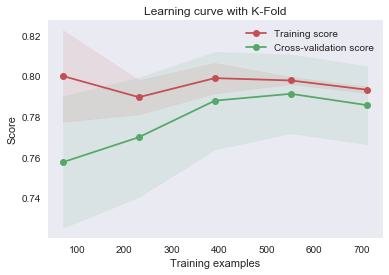

In [235]:
plot_learning_curve(model, "Learning curve with K-Fold", X, y, cv=cv)

# Visualise

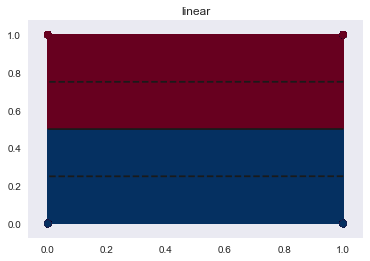

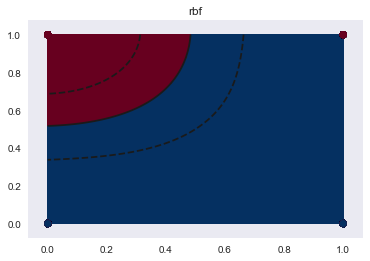

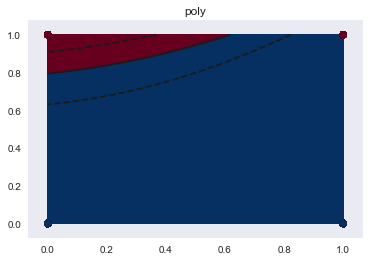

In [236]:
# Plot with standard configuration of SVM
%run plot_svm
plot_svm(df)

Any value in the blue survived while anyone in the read did not. Checkout the graph for the linear transformation. It created its decision boundary right on 50%! 

# CONCLUSIONS

RBF MODEL:

First, we used RBF Model with gamma=3.0 comparing it to performance with a gamma=5.0, which showed that score metric was basically the same.
More TN, less FP, more FN, less TP than Linear Model case.
Worse results in precision than Linear Model case
AUC score is 0.52, so we can consider this model a fail
Optimizing in this case improves performance of the algorithm, as we can see when we compare the score-plots. This optimizing is done by the function GridSearchCV, similar to the GridSearch Optimizing Algorithm that was used in previous exercises.


RBF Normalized MODEL:

The model is the same as the one used in RBF, but we normalize the data. We expect better results, as in RBF Model not-normalized (RBF-nn onwards) were quite bad. The accuracy score improves from 61.4% to an acceptable 80.71%, which confirms the previous sentence.
The confusion matrix offers a higher increase in TP than the decrease in TN; so, we can say that this algorithm is much better as the one which used RBF-nn. Looking at the ROC Curve, it rapidly increases to values next to 0.8, when ROC Curve RBF-nn reaches 0.8 at a slower pace.
AUC score is almost 0.8, so we can consider this model a good one. 
Accuracy is the same as is RBF-nn after training and evaluation with K-Fold, so we can infer that normalization doesn’t impact this measure.
Optimizing in this case improves performance of the algorithm, as we can see when we compare the score-plots. This optimizing is done by the function GridSearchCV, similar to the GridSearch Optimizing Algorithm that was used in previous exercises.



GAUSSIAN NAIVE BAYES MODEL:


We are going to try this model, to try to give another point of view that isn’t proposed in the exercise description. Some things must be said before starting: Gaussian Naives Model (GNB onwards) uses normalized data, and if you provide not normalized data, it normalizes them automatically; GNB doesn’t allow tuning algorithms, because the function GaussianNB() doesn’t allow parameters, so the improvement for this algorithm comes with pre-processing data. But this GNB with no pre-processing gives better performance than the one “improved” as we will explain.
Using GNB gives as accuracy score of 81.61%, higher than any other used for this exercise. Null accuracy is lower as accuracy.
GNB gives more TN and almost the same TP than RBF Normalized, so we can say that GNB is the best at the moment for this exercise. This fact makes the rate of precision, recall, f1-score and support better than any other algorithm used before.
As we could expect, ROC Curve reaches 0.8 even before than RBF Model Normalized. So the AUC Score is higher, with a value of 0.805.
After training and evaluation with K-Fold, accuracy is 79%, a remarkable fact because in the previous algorithms, K-Fold improved the accuracy; but not in this one.
We can´t use the tuning function GridSearchCV, so we can´t compare the learning curves with and without K-Fold.


GAUSSIAN NAIVE BAYES MODEL with PCA (GNB-PCA onwards):

For this last part, we will pre-process data with PCA (Principle Component Analysis). Principal component analysis (PCA) is a statistical procedure that uses an orthogonal transformation to convert a set of observations of possibly correlated variables into a set of values of linearly uncorrelated variables called principal components.
The overall impression of this technique is that is helpless, so we can’t state that pre-processing decreases performance in GNB, just that it decreases it for this dataset.
Accuracy score is now 65.91%, 15 points lower than “pure” GNB. Null accuracy is just 5 points lower than accuracy. As we could expect, confusion matrix shows that less TN and TP are detected and precision, recall, f1-score and support are worse than in GNB.
ROC Curve reaches 0.8 at a slower pace than GNB.
All these reasons are summed up in the AUC Score, which is 0.631, a poor result, 0.17 points less than GNB.
K-Fold now improves the performance, giving an 79% accuracy.
We can´t use the tuning function GridSearchCV, so we can´t compare the learning curves with and without K-Fold.

